In [1]:
import pandas as pd
import numpy as np
import os
import warnings
from sklearn.preprocessing import MinMaxScaler

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
current_directory = os.getcwd()
current_directory

'/Users/ruijuewang/Desktop/DFT/Sem2/FT5005 ML for Finance/Group Project/github/FT5005-Group6/Cleaned Data'

## EBITDA - LSTM Model

In [3]:
processed_df = pd.read_csv('EBITDA_new.csv')
processed_df.head()

,ticker,fiscalQuarter,commonSharesOutstanding_,commonSharesTraded_,capitalExpenditure_,netIncome_,operatingIncome_,shareholdersEquity_,totalAssets_,EPS_,...,salePrice,realGDPSA,m2SA,m2m1GrowthGap,m2Velocity,primeRate,revenue_,EBITDA_lag1,year,quarter
0,0,2013Q1,-0.000933,12.247579,0.0,-0.073272,-0.095742,-0.003005,0.0,0.0,...,13.564960,-0.867729,9.261987,0.172473,1.581,3.25,-0.003,NaN,2013,1
1,0,2013Q2,-0.000933,12.247579,0.0,-0.073210,-0.095754,-0.003005,0.0,0.0,...,13.651304,-0.849252,9.272702,-0.640550,1.572,3.25,-0.003,50.369,2013,2
2,0,2013Q3,-0.000933,12.247579,0.0,-0.073519,-0.095692,-0.003005,0.0,0.0,...,13.650265,-0.790315,9.286502,-0.328302,1.571,3.25,-0.003,42.617,2013,3
3,0,2013Q4,-0.000933,12.247579,0.0,-0.072407,-0.095729,0.000000,0.0,0.0,...,13.978878,-0.729457,9.305890,-1.494308,1.563,3.25,0.000,46.147,2013,4
4,0,2014Q1,-0.000933,12.247579,0.0,-0.073519,-0.095692,-0.006018,0.0,0.0,...,13.796973,-0.753759,9.321372,-1.579023,1.539,3.25,-0.006,67.587,2014,1


In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

2025-04-30 22:09:41.956270: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
# Select features and target variable
target = 'EBITDA'
# features exclude: 
features = [col for col in processed_df.columns if col not in [ target, 'fiscalQuarter']
]

# Remove missing values
processed_df = processed_df.dropna(subset=features + [target])

# Split the dataset based on year

train_df = processed_df[processed_df['year'] <= 2020]
test_df = processed_df[processed_df['year'] > 2020]

# Define train and test sets for scaling
X_train_raw = train_df[features]
y_train_raw = train_df[target].values.reshape(-1, 1)
X_test_raw = test_df[features]
y_test_raw = test_df[target].values.reshape(-1, 1)

# Scale the features and target
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train_raw)
y_train_scaled = scaler_y.fit_transform(y_train_raw)
X_test_scaled = scaler_X.transform(X_test_raw)
y_test_scaled = scaler_y.transform(y_test_raw)

In [6]:
X_train_raw.shape

(333, 28)

In [7]:
# Convert to supervised learning format
def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

In [8]:
# Create sequences
seq_length = 10
X_train, y_train = create_sequences(X_train_scaled, y_train_scaled, seq_length)

# Create sequences for test data
X_test, y_test = create_sequences(X_test_scaled, y_test_scaled, seq_length)

print(f'X_train shape: {X_train.shape}') 
print(f'y_train shape: {y_train.shape}')

X_train shape: (323, 10, 28)
y_train shape: (323, 1)


In [9]:
import tensorflow.keras.backend as K
import tensorflow as tf

def r2_keras(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - ss_res / (ss_tot + K.epsilon())

In [10]:
# Build model

import tensorflow as tf
import random

def set_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seeds(42)

# model = Sequential([
#     LSTM(30, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
#     Dropout(0.2),
#     LSTM(30),
#     Dropout(0.2),
#     Dense(1)
# ])

model = Sequential([
    LSTM(30, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.1),
    Dense(1)
]) 

model.compile(optimizer='adam', loss='mse')
# model.compile(optimizer='adam', loss='mse', metrics=[r2_keras])

X_val = X_test.copy()
y_val = y_test.copy()

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)


# history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_val, y_val))

Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.1381 - val_loss: 0.0879
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0689 - val_loss: 0.0653
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0511 - val_loss: 0.0591
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0429 - val_loss: 0.0543
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0354 - val_loss: 0.0524
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0407 - val_loss: 0.0513
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0313 - val_loss: 0.0486
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0300 - val_loss: 0.0475
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0205 - val_loss: 0.0475
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0239 - val_loss: 0.0482
Epoch 11/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0214 - val_loss: 0.0470
Epoch 12/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step -

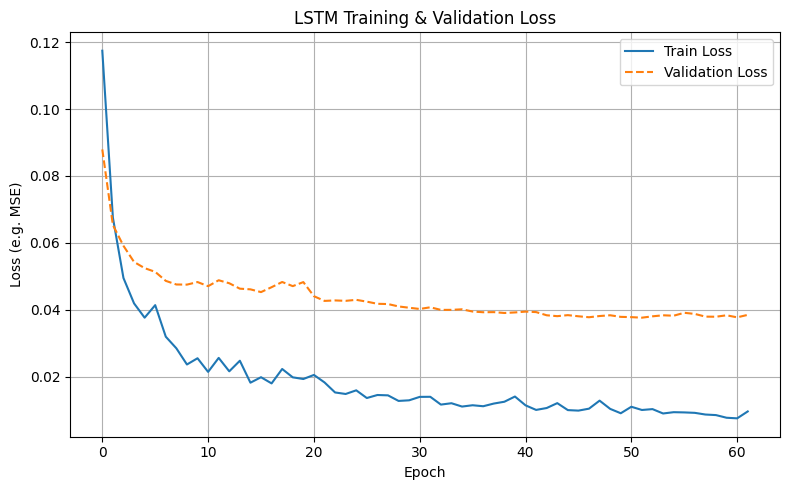

In [11]:
import matplotlib.pyplot as plt

# 画 Loss 曲线
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
plt.title('LSTM Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (e.g. MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# plt.figure(figsize=(8, 5))
# plt.plot(history.history['r2_keras'], label='Train R2')
# plt.plot(history.history['val_r2_keras'], label='Validation R2', linestyle='--')
# plt.title('LSTM Training & Validation R2')
# plt.xlabel('Epoch')
# plt.ylabel('R2')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Train RMSE: 19.3159
Train R2: 0.9363


Text(0.5, 1.0, 'Train Prediction vs Ground Truth')

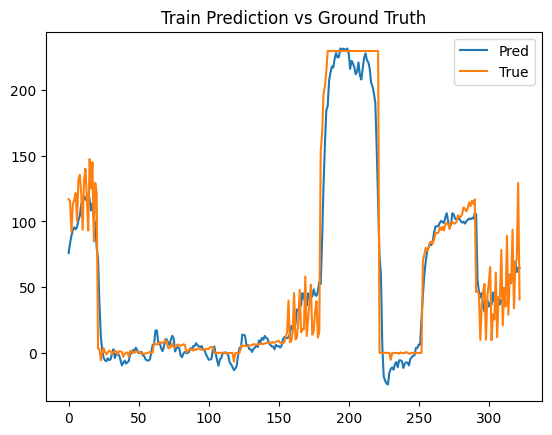

In [12]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred = model.predict(X_train)
y_train_inv = scaler_y.inverse_transform(y_train)
y_pred_inv = scaler_y.inverse_transform(y_pred)

mse = np.sqrt(mean_squared_error(y_train_inv, y_pred_inv))
r2 = r2_score(y_train_inv, y_pred_inv)
print(f"Train RMSE: {mse:.4f}")
print(f"Train R2: {r2:.4f}")

plt.plot(y_pred_inv, label='Pred')
plt.plot(y_train_inv, label='True')
plt.legend()
plt.title("Train Prediction vs Ground Truth")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test RMSE: 45.8423
Test R2: 0.6856


Text(0.5, 1.0, 'Test Prediction vs Ground Truth')

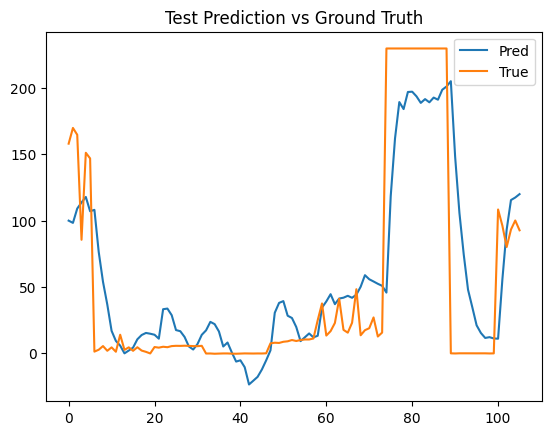

In [13]:
# Predict and evaluate
from sklearn.metrics import mean_squared_error, r2_score

y_pred = model.predict(X_test)
y_test_inv = scaler_y.inverse_transform(y_test)
y_pred_inv = scaler_y.inverse_transform(y_pred)

mse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
r2 = r2_score(y_test_inv, y_pred_inv)
print(f"Test RMSE: {mse:.4f}")
print(f"Test R2: {r2:.4f}")

plt.plot(y_pred_inv, label='Pred')
plt.plot(y_test_inv, label='True')
plt.legend()
plt.title("Test Prediction vs Ground Truth")